In [1]:
import glob
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [2]:
sorted(glob.glob('data/raw/*_*_0[1-4]*'))

['data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅',
 'data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
 'data/raw/01_11_03_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_11_04_エネマネハウス_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅',
 'data/raw/01_12_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
 'data/raw/01_12_02_エネマネハウス_XperiaZ3_ズボン_裏上_異常_まっすぐ外出',
 'data/raw/01_12_03_エネマネハウス_XperiaZ3_カバン_裏上_異常_まっすぐ外出',
 'data/raw/01_13_01_エネマネハウス_XperiaZ3_胸ポケット

In [3]:
def _get_dir_list(path):
    return glob.glob(path)

def _get_file_list_in_dir(d):
    f = glob.glob(d + '/*.csv')
    f.sort()
    return f[:3]

def _get_df_from_csv(f):
    is_iOS = "iphone" in f
    df = pd.read_csv(f)

    if is_iOS:
        # rename column name to integrate
        df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
        # remove unsaved parameters
        del df['magneticField.accuracy']
        del df['magneticField.field.x']
        del df['magneticField.field.y']
        del df['magneticField.field.z']
    else:
        # rename column name to integrate
        df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
        df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
        # remove unsaved parameters
        del df['temperature']
        del df['humidity']
        del df['proximity']

    # remove data while rssi is not recorded
    buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
    if len(buf) == 0:
        print('x', end='')
        return None
    
    first_rssi_idx = buf[0]
    df = df.ix[first_rssi_idx:, :]

    # type specify
    for c in df.columns[1:]:
        df[c] = df[c].astype(float)

    # adjust the value of button pushed data 
    df.loc[df['btn_push'] == -1, 'btn_push'] = 0

    # convert -1 to NaN
    df[df == -1] = np.nan

    print('.', end='')

    return df

def load(path='data/raw/*_*_0[1-4]*'):
    """
    load csv data from the specified path
    """
    print("path = " + path)
    d = _get_dir_list(path)
    title = [os.path.basename(_d) for _d in d]

    r = []
    for _d in d[:2]:
        print(_d)
        title = os.path.basename(_d)
        file_list = _get_file_list_in_dir(_d)
        fname_list = [os.path.basename(_f) for _f in file_list]
        df_list = [_get_df_from_csv(f) for f in file_list]
        print('')
        r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

    ds = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
    return ds

In [14]:
def _time_range_around_button_push(df, before=0, after=0):
    t = df[df['btn_push'] == 1].index
    point = t[0] if len(t) > 0 else df.index[-1] - 150
    return df.loc[(point - before):(point + after)]

def get_data(ds, title='.*', fname='.*', before=None, after=0, column=None):
    """
    return copied list of dataframe, limited by column and frame number.
    """
    # extract the [title, fname, dataframe]
    dfm = ds[ds['title'].str.contains(title)]
    dfm = dfm[dfm['fname'].str.contains(fname)]
    # to list of dataframe
    dfl = [d for d in dfm['dataframe'].tolist() if d is not None]
    # copy dataframe
    dfl = [df.copy() for df in dfl]
    # interpolate NaN
    dfl = [df.apply(pd.Series.interpolate) for df in dfl]
    # limit the time range
    dfl = [_time_range_around_button_push(d, before, after) for d in dfl]
    # limit the column
    if column != None: dfl = [d[column] for d in dfl]
    print("extracted %d dataframes" % (len(dfl)))
    return dfl

In [15]:
def _get_mean_std_3d(dfl, x, y, z):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    y = merged_df[y]
    z = merged_df[z]
    std = (x*x + y*y + z*z).apply(lambda x: math.sqrt(x)).std()
    x_mean = x.mean()
    y_mean = y.mean()
    z_mean = z.mean()
    return (x_mean, y_mean, z_mean, std)

def _get_mean_std(dfl, x):
    merged_df = pd.concat([df for df in dfl])
    x = merged_df[x]
    std = x.std()
    mean = x.mean()
    return (mean, std)

def get_mean_std(dfl, column):
    mean = []
    std = []
    for c in column:
        if type(c) == list:
            (mx, my, mz, _s) = _get_mean_std_3d(dfl, c[0], c[1], c[2])
            mean.extend([mx, my, mz])
            std.extend([_s]*3)
        else:
            (_mean, _s) = _get_mean_std(dfl, c)
            mean.append(_mean)
            std.append(_s)
    return (mean, std)

def list_flatten(l):
    _l = []
    for l in l:
        if type(l) == list: _l.extend(l)
        else:               _l.append(l)
    return _l

#_df = dfl[0]
def normalize(dfl, column, mean_std):
    dfl_new = []
    for df in dfl:
        df_new = pd.DataFrame()
        for (c, m, s) in zip(list_flatten(column), mean_std[0], mean_std[1]):
            #print(c, m, s)
            df_new[c] = (df[c] - m)/s
            #print(df_new[c])
            #print(df_new[c])
        dfl_new.append(df_new)
    return dfl_new

In [16]:
# normalize the normal and outlier data by mean and sigma of normal data
def get_normalized_data(ds, title_n, title_o, column, fname=".*", before=0, after=0):
    dfl_n = get_data(ds, title=title_n, fname=fname, before=before, after=after, column=list_flatten(column))
    dfl_o = get_data(ds, title=title_o, fname=fname, before=before, after=after, column=list_flatten(column))

    mean_std = get_mean_std(dfl_n, column)
    dfl_n = normalize(dfl_n, column, mean_std)
    dfl_o = normalize(dfl_o, column, mean_std)

    np_n = [df.as_matrix() for df in dfl_n]
    np_o = [df.as_matrix() for df in dfl_o]
    
    return np_n, np_o

In [17]:
def sample2():
    ds = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    dfl = get_data(ds, before=6, after=0, column=['rssi.b','rssi.a','linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push'])
    return dfl[0]
sample2()

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes


,rssi.b,rssi.a,linear_accel[0],linear_accel[1],linear_accel[2],btn_push
643,-36.0,-25.5,-0.115767,0.002029,0.526729,0.0
644,-34.0,-25.0,0.120929,0.029972,0.608754,0.0
645,-32.0,-25.0,-0.242042,0.052567,0.493274,0.0
646,-33.0,-25.0,-0.491172,0.254213,0.432572,0.0
647,-34.0,-24.5,-0.700672,0.334507,0.613842,0.0
648,-32.5,-24.0,-0.369455,0.505239,0.427036,0.0
649,-31.0,-24.0,-0.463415,0.443812,0.667643,1.0


path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
path = data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
extracted 3 dataframes
extracted 3 dataframes
[[  0.           8.5003724   10.76833816]
 [  0.           6.75120485   8.5003724 ]
 [  0.           6.75120485  10.76833816]]
[[ 213.03142723  216.08992154  216.11176133]
 [ 175.89596252  178.10115034  178.37824257]
 [ 193.03871568  195.39987538  195.45995085]]


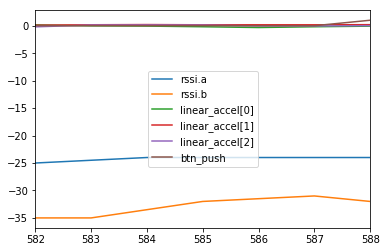

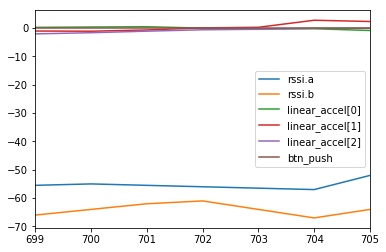

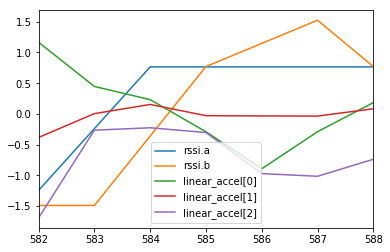

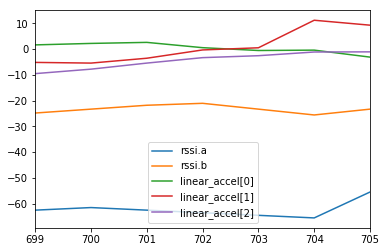

In [19]:
def sample3():
    # load dataset
    ds_nml = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds_out = load('data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出')

    # set column
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push']]

    # get around button pushed time
    dfl_nml = get_data(ds_nml, before=6, after=0, column=list_flatten(column))
    dfl_out = get_data(ds_out, before=6, after=0, column=list_flatten(column))

    # normalize
    mean_std = get_mean_std(dfl_nml, column)
    dfl_nml_n = normalize(dfl_nml, column, mean_std)
    dfl_out_n = normalize(dfl_out, column, mean_std)

    # plot graph
    dfl_nml[1].plot()
    dfl_out[1].plot()
    dfl_nml_n[1].plot()
    dfl_out_n[1].plot()

    # calc k-NN distance
    from sklearn.neighbors import NearestNeighbors
    X_nml = [d.values.flatten() for d in dfl_nml_n]
    X_out = [d.values.flatten() for d in dfl_out_n]
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
    nbrs.fit(X_nml)

    distances, indices = nbrs.kneighbors(X_nml)
    print(distances)
    distances, indices = nbrs.kneighbors(X_out)
    print(distances)

    df_result = pd.DataFrame([[]])
sample3()

In [20]:
def sample1():
    ds = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    ds.iloc[0]['dataframe'].info()
    return ds.info()
sample1()

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 175 to 746
Data columns (total 31 columns):
date                572 non-null object
rssi.a              281 non-null float64
rssi.b              285 non-null float64
remote_rssi         567 non-null float64
linear_accel[0]     568 non-null float64
linear_accel[1]     568 non-null float64
linear_accel[2]     568 non-null float64
accelerometer[0]    568 non-null float64
accelerometer[1]    568 non-null float64
accelerometer[2]    568 non-null float64
gravity[0]          566 non-null float64
gravity[1]          566 non-null float64
gravity[2]          566 non-null float64
gyro[0]             567 non-null float64
gyro[1]             567 non-null float64
gyro[2]             567 non-null float64
rotation[0]         565 non-null float64
rotation[1]         565 non-null float64
rotation[2]         565 non-null float64


In [21]:
######################## eval by rssi
def sample4():
    ds = load('data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅')
    # get every 100msec rssi
    df = get_data(ds, before=0, after=50, column=['date','rssi.a','rssi.b'])[0].iloc[::5]
    display(df)
    df_mean = df.rolling(window=3, min_periods=3).mean()
    display(df_mean)

    print("rssi.a ", end="")
    print(max(df_mean.iloc[2:]['rssi.a']))
    print("rssi.b ", end="")
    print(max(df_mean.iloc[2:]['rssi.b']))

sample4()

path = data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes


,date,rssi.a,rssi.b
649,2017/04/06 14:02:07.765,-24.0,-31.0
654,2017/04/06 14:02:07.868,-23.0,-32.0
659,2017/04/06 14:02:07.973,-23.0,-31.0
664,2017/04/06 14:02:08.072,-23.0,-33.0
669,2017/04/06 14:02:08.174,-22.0,-32.0
674,2017/04/06 14:02:08.274,-23.0,-33.0
679,2017/04/06 14:02:08.378,-22.0,-31.5
684,2017/04/06 14:02:08.482,-22.5,-31.0
689,2017/04/06 14:02:08.580,-22.0,-32.0
694,2017/04/06 14:02:08.682,-22.0,-33.0


,date,rssi.a,rssi.b
649,2017/04/06 14:02:07.765,NaN,NaN
654,2017/04/06 14:02:07.868,NaN,NaN
659,2017/04/06 14:02:07.973,-23.333333,-31.333333
664,2017/04/06 14:02:08.072,-23.000000,-32.000000
669,2017/04/06 14:02:08.174,-22.666667,-32.000000
674,2017/04/06 14:02:08.274,-22.666667,-32.666667
679,2017/04/06 14:02:08.378,-22.333333,-32.166667
684,2017/04/06 14:02:08.482,-22.500000,-31.833333
689,2017/04/06 14:02:08.580,-22.166667,-31.500000
694,2017/04/06 14:02:08.682,-22.166667,-32.000000


rssi.a -22.0
rssi.b -31.3333333333


In [22]:
def sample5():
    ds = load('data/raw/01_0[12]_01_*')
    column = ['rssi.a','rssi.b',['linear_accel[0]','linear_accel[1]','linear_accel[2]','btn_push']]
    return get_normalized_data(ds,
                        title_n='01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅',
                        title_o ='01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出',
                        before=6, after=0, column=column
                       )
sample5()

path = data/raw/01_0[12]_01_*
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
...
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
...
extracted 3 dataframes
extracted 3 dataframes


([array([[-2.24882957, -2.24217501,  0.00802648, -0.7490215 ,  1.44447268],
         [-1.24403338, -0.7354334 ,  1.02520122, -0.62894129,  1.79696902],
         [-1.24403338,  0.7713082 , -0.53462343, -0.53184433,  1.3007043 ],
         [-1.24403338,  0.0179374 , -1.60522978,  0.33470862,  1.03984435],
         [-0.23923719, -0.7354334 , -2.5055322 ,  0.67976104,  1.81882993],
         [ 0.765559  ,  0.3946228 , -1.08216668,  1.41345932,  1.01605427],
         [ 0.765559  ,  1.52467901, -1.48594976,  1.14948776,  2.05003314]]),
  array([[-1.24403338, -1.48880421,  1.16665714, -0.38218257, -1.69154676],
         [-0.23923719, -1.48880421,  0.44751188,  0.00509458, -0.26397428],
         [ 0.765559  , -0.358748  ,  0.23274656,  0.15451044, -0.22493233],
         [ 0.765559  ,  0.7713082 , -0.29003271, -0.0280197 , -0.30244299],
         [ 0.765559  ,  1.14799361, -0.89150241, -0.03218764, -0.97027548],
         [ 0.765559  ,  1.52467901, -0.28830427, -0.03464665, -1.01404227],
         [